In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 8
sc.set_figure_params(dpi=100, dpi_save=600, frameon=False, figsize=(5,5))
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"
%config InlineBackend.figure_format = 'retina'

In [3]:
adata = sc.read_h5ad('../data/cxg.h5ad', backed='r')
adata = adata[(adata.obs.MetaType.isin(['Neurons','SGC'])) & (adata.obs.Conditions == 'Naive')].to_memory()
adata.layers['counts'] = adata.raw.X.copy()
adata.layers['scVI_gene'] = adata.X.copy()
adata.X = adata.layers['counts'].copy()
adata.obs.Source = adata.obs.Source.apply(lambda x: f"Techameena_{x.split('_')[-1]}" if x.startswith('Lab') else x)
del adata.raw
adata.var_names = adata.var.gene_name.to_list()
adata.var_names_make_unique()

In [6]:
adata.obs.MetaType = adata.obs.NociceptiveType.copy()
adata.obs.MetaType = adata.obs.MetaType.apply(lambda x: 'NFs' if x.startswith('NF') else x)

In [19]:
adata = adata[(adata.obs.MetaType.isin(['Nociceptors','NFs'])) & (adata.obs.Conditions == 'Naive')].copy()

In [20]:
def pp(adata):
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    adata.layers['log_norm'] = adata.X.copy()
    return adata

In [21]:
adatas = [adata[adata.obs.Source == source].copy() for source in adata.obs.Source.cat.categories]
adatas = [pp(adata) for adata in adatas]

In [22]:
adata_neu = sc.concat(adatas)
sc.pp.filter_genes(adata_neu, min_cells=3)

In [23]:
sc.pp.neighbors(adata_neu, use_rep='X_scANVI', metric='cosine')
sc.tl.umap(adata_neu, min_dist=0.3)

In [24]:
adata_neu.obs.MetaType = adata_neu.obs.NociceptiveType.copy()
adata_neu.obs.MetaType = adata_neu.obs.MetaType.apply(lambda x: 'NFs' if x.startswith('NF') else x)

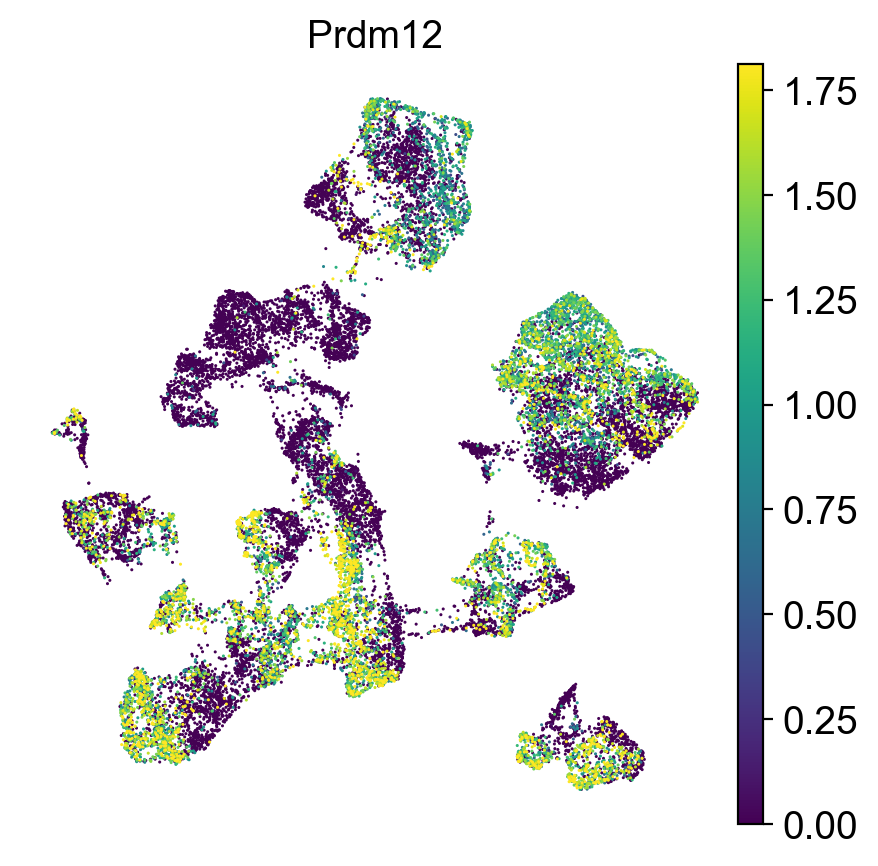

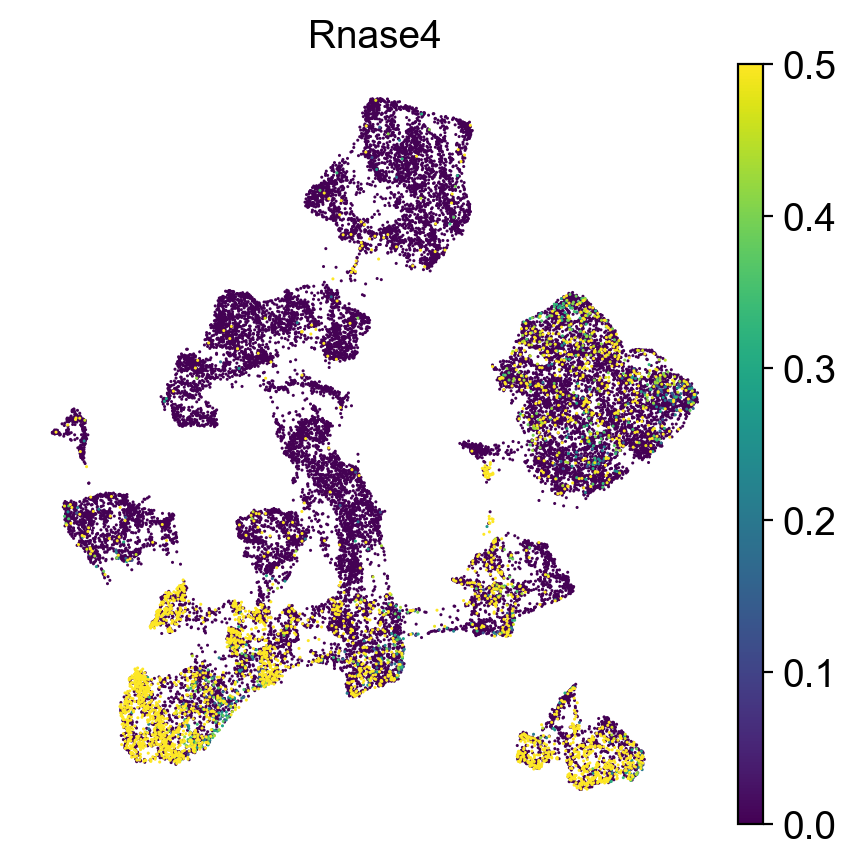

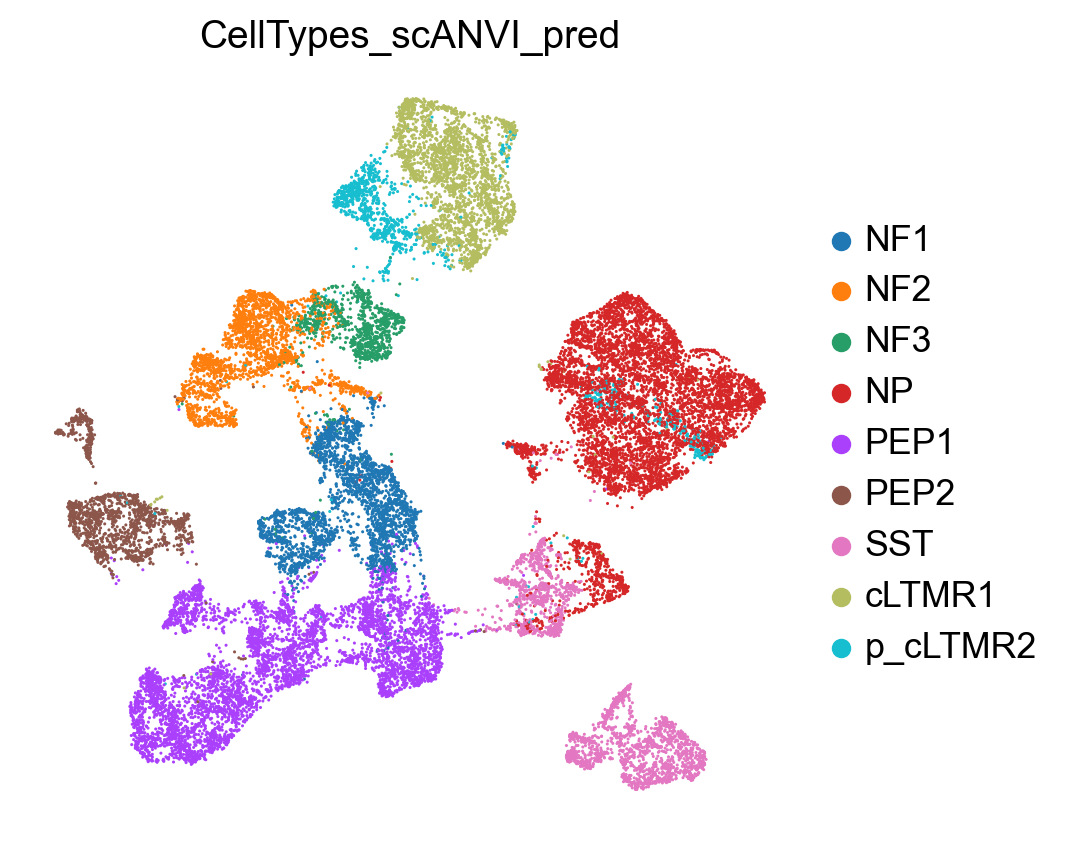

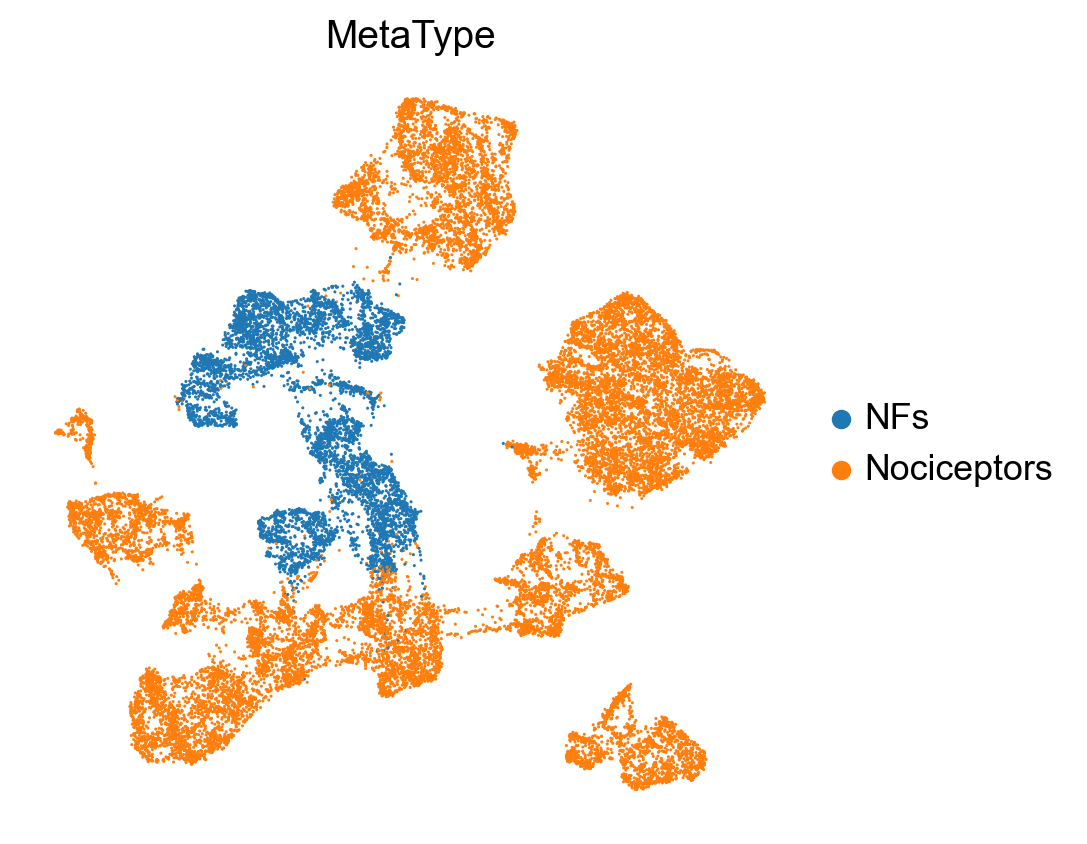

: 

In [125]:
sc.pl.umap(adata_neu, color=['Prdm12'], vmin=0, vmax='p95', layer='log_norm', save='_neurons_Prdm12.pdf')
sc.pl.umap(adata_neu, color=['Rnase4'], vmin=0, vmax=0.5, layer='log_norm', save='_neurons_Rnase4.pdf')
sc.pl.umap(adata_neu, color=['CellTypes_scANVI_pred'], save='_neurons_CellTypes_scANVI_pred.pdf')
sc.pl.umap(adata_neu, color=['MetaType'], save='_neurons_MetaType.pdf')

In [37]:
from decoupler import get_pseudobulk
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# create pseudobulk from raw counts
adata_neu.X = adata_neu.layers['counts'].toarray().copy()
pbs_adata = get_pseudobulk(adata_neu, 'donor_id', 'MetaType', min_prop=0.1)

# create DeseqDataSet object and run DE analysis
dds = DeseqDataSet(adata = pbs_adata, design_factors=['Source', 'MetaType'], n_cpus=8, quiet=True)
sc.pp.filter_genes(dds, min_cells = 3)
dds.deseq2()

/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/pydeseq2/dds.py:264: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting dispersions...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.05 seconds.



In [44]:
noci_stat_res = DeseqStats(dds, contrast=('MetaType', 'Nociceptors', 'NFs'), quiet=True)
noci_stat_res.summary()
noci_de = noci_stat_res.results_df.sort_values('stat', ascending = False)
noci_de[noci_de.log2FoldChange > 2.5].to_csv('./tables/01_noci_de.csv')
noci_de[noci_de.log2FoldChange > 2.5]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Grik1,1385.180682,4.809987,0.204102,23.566609,8.482599e-123,1.650054e-119
Syt9,162.910769,2.605349,0.112124,23.236278,1.958075e-119,3.428002e-116
Trpc3,178.247039,3.589910,0.155331,23.111345,3.560637e-118,5.666916e-115
Cd44,319.158183,4.049338,0.176636,22.924789,2.630016e-116,3.836974e-113
Ldb2,276.752355,3.255444,0.149734,21.741587,8.298048e-105,9.079621e-102
...,...,...,...,...,...,...
Wnt11,1.806947,2.881192,0.705013,4.086722,4.375105e-05,1.653259e-04
Serpina11,5.341382,2.604031,0.656094,3.968988,7.217845e-05,2.624903e-04
Fmod,1.742370,2.561310,0.649325,3.944572,7.994256e-05,2.886870e-04
Dkkl1,2.273144,2.528090,0.667805,3.785673,1.532934e-04,5.251874e-04


In [45]:
nf_stat_res = DeseqStats(dds, contrast=('MetaType', 'NFs', 'Nociceptors'), quiet=True)
nf_stat_res.summary()
nf_de = nf_stat_res.results_df.sort_values('stat', ascending = False)
nf_de[nf_de.log2FoldChange > 2.5].to_csv('./tables/01_nf_de.csv')
nf_de[nf_de.log2FoldChange > 2.5]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Slc16a6,48.172345,3.642760,0.139204,26.168511,6.068194e-151,5.311794e-147
Scn8a,431.856167,3.144546,0.120644,26.064580,9.196047e-150,5.366506e-146
Kank4,92.788483,2.679225,0.106214,25.224877,2.137255e-140,7.483385e-137
Gabrg1,48.538916,4.445967,0.178887,24.853481,2.371220e-136,6.918825e-133
Syt2,296.094986,2.954001,0.121086,24.395872,1.891731e-131,4.731219e-128
...,...,...,...,...,...,...
Tmem28,8.422176,2.577112,0.679967,3.790055,1.506139e-04,5.170192e-04
Gm32647,178.169764,2.823124,0.746360,3.782521,1.552477e-04,5.311553e-04
Mup20,1.209252,3.582618,1.031558,3.473016,5.146447e-04,1.596795e-03
B230334C09Rik,2.291018,2.519134,0.849120,2.966757,3.009582e-03,7.962635e-03


In [76]:
top_genes = {
    'NFs': nf_de[nf_de.log2FoldChange > 2.5].head(3).index.to_list(),
    'Nociceptors': noci_de[noci_de.log2FoldChange > 2.5].head(3).index.to_list() + ['Rnase4']
}

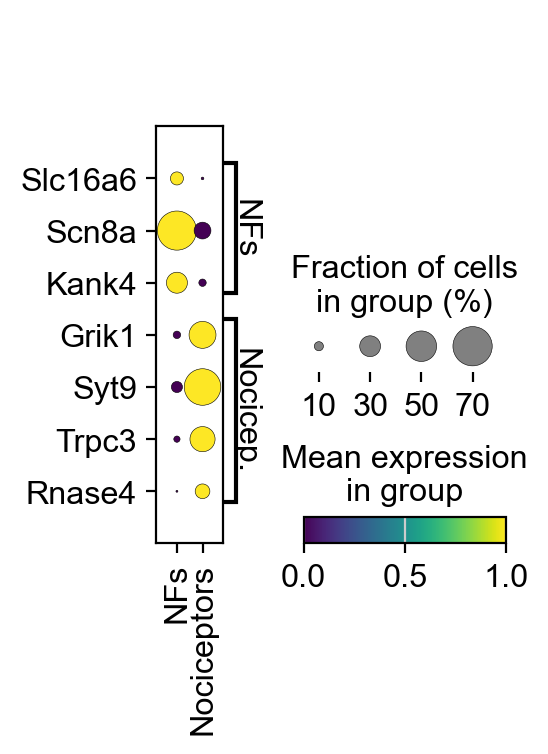

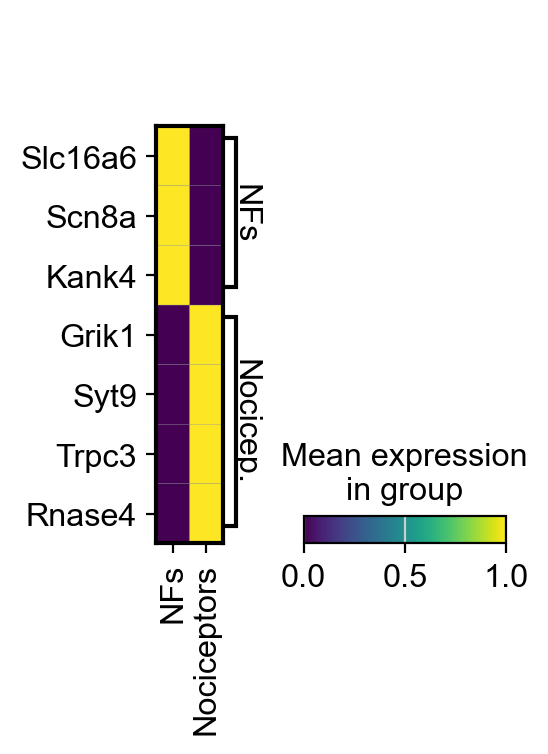

In [77]:
sc.pl.dotplot(adata_neu, var_names=top_genes, groupby='MetaType', use_raw=False, cmap='viridis', standard_scale='var', swap_axes=True, save='neurons_top_genes.pdf')
sc.pl.matrixplot(adata_neu, var_names=top_genes, groupby='MetaType', use_raw=False, cmap='viridis', standard_scale='var', swap_axes=True, save='neurons_top_genes.pdf')

In [73]:
np.where(noci_de.index == 'Rnase4')[0]

array([73])

In [70]:
noci_de[noci_de.log2FoldChange > 2.5].loc['Rnase4',:].to_frame()

,Rnase4
baseMean,3.063765e+01
log2FoldChange,3.450540e+00
lfcSE,2.371646e-01
stat,1.454913e+01
pvalue,5.914747e-48
padj,5.566859e-46


In [16]:
sk_color = {
 'NF1': '#ffd900',
 'NF2': '#ff8c00',
 'NF3': '#ff4040',
 'NP': '#67cd00',
 'PEP1': '#87cefa',
 'PEP2': '#1c86ee',
 'SST': '#104e8b',
 'cLTMR1': '#98f5ff',
 'p_cLTMR2': '#00ced1',
 'NFs': '#104e8b',
 'Nociceptors': '#ff8c00'
 }

In [7]:
adata_neu.obs.CellTypes_scANVI_pred.cat.categories

Index(['NF1', 'NF2', 'NF3', 'NP', 'PEP1', 'PEP2', 'SST', 'cLTMR1', 'p_cLTMR2'], dtype='object')

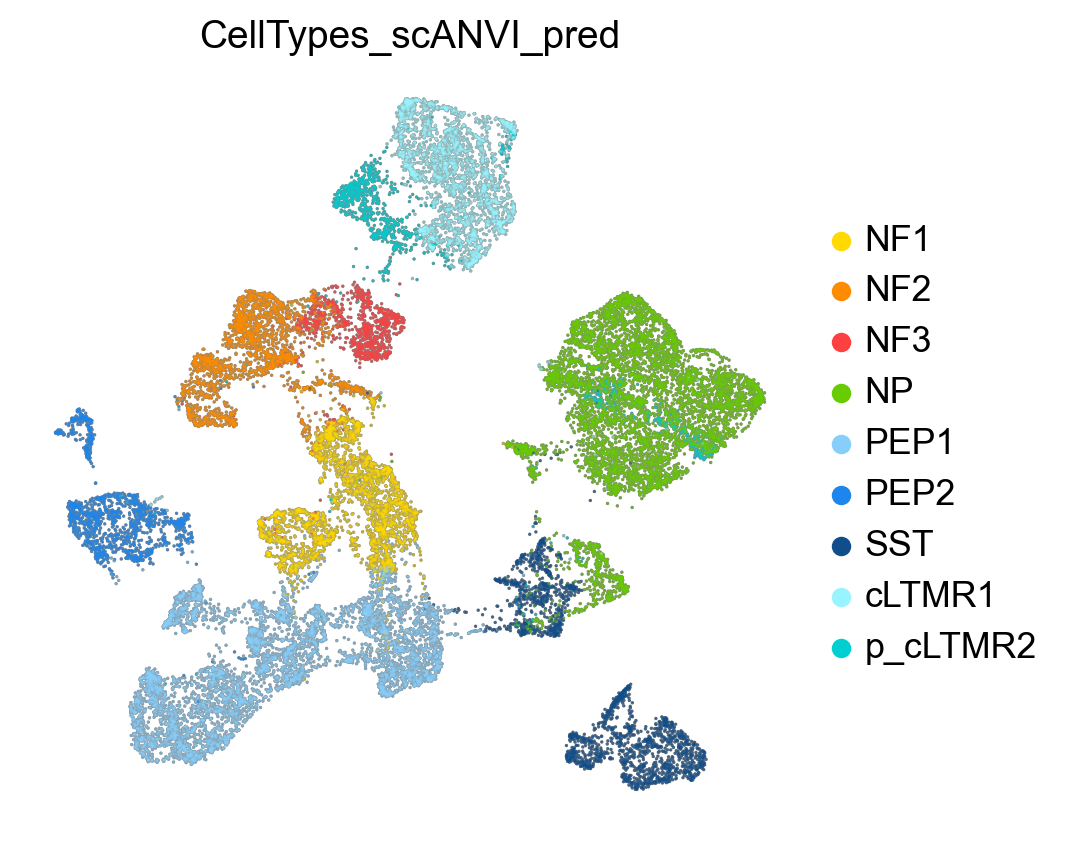

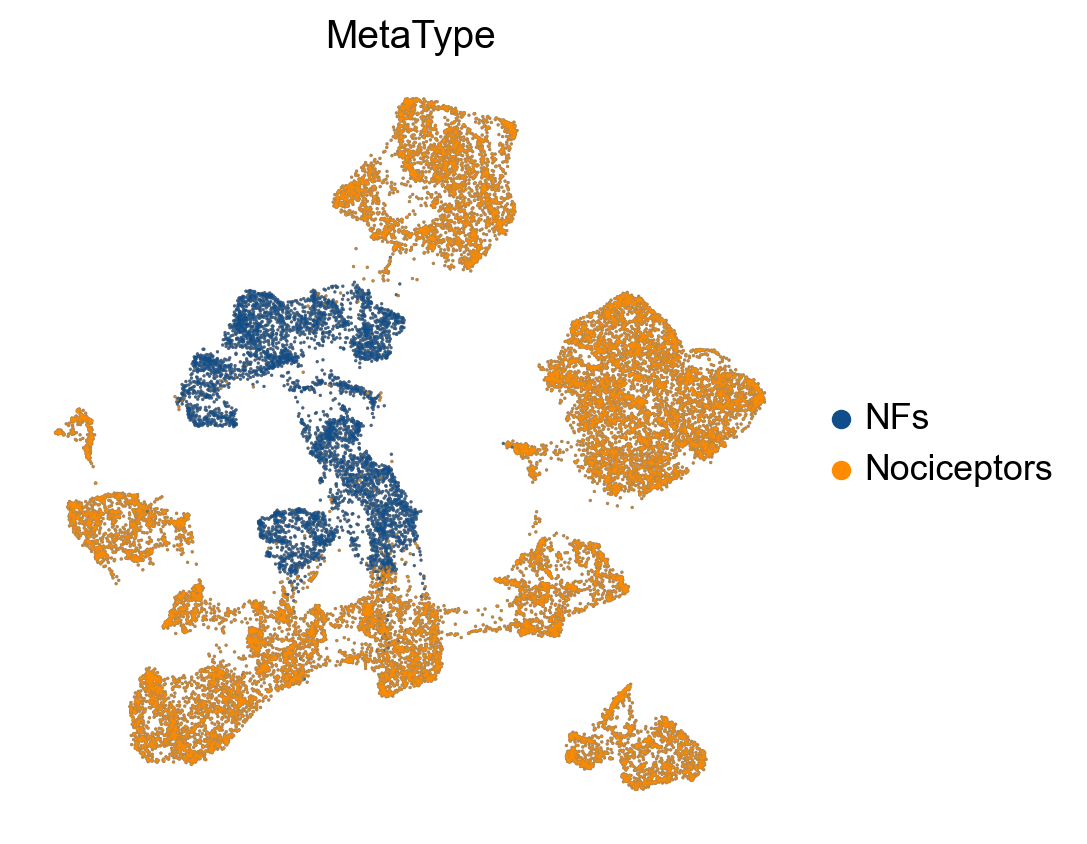

In [18]:
sc.pl.umap(adata_neu, color=['CellTypes_scANVI_pred'], palette=sk_color, alpha=0.5, legend_fontoutline=2,
           add_outline=True, outline_color=('white','grey'), outline_width=(0, 0.05), save='_neurons_CellTypes_scANVI_pred_new_params.pdf')
sc.pl.umap(adata_neu, color=['MetaType'], palette=sk_color, alpha=0.5, legend_fontoutline=2,
           add_outline=True, outline_color=('white','grey'), outline_width=(0, 0.05), save='_neurons_MetaType_new_params.pdf')